<a href="https://colab.research.google.com/github/succSeeded/MSc/blob/main/mcdnn/Assignment%201%20-%20Dynamic%20Neural%20Networks%20-%20Kirdin%20Matvei.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Notebook made by: **Kirdin Matvei**, e-mail: `mdkirdin@student.hse.ru`

# Question 1.

**Build and Train a Simple Neural Network.**

* Create a basic neural network from scratch using Python and a library of your choice (e.g., TensorFlow, PyTorch, or Keras).
* Explain the importance of layers, activation functions, and a training loop for backpropagation and Gradient descent.
* Document your code, explain each layer's purpose, and discuss the network's performance. You can use any dataset for explaining.

In [1]:
%load_ext jupyter_black

In [2]:
import math
import torch
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import FashionMNIST
from torchsummary import summary
import matplotlib.pyplot as plt

Fix the random generator for the purpose of reproducability.

In [3]:
random_seed = 42
rng = torch.Generator()
rng.manual_seed(random_seed)

In this example I will use the ```Fashion MNIST``` dataset, as it is readily available and comes with PyTorch. It contains 28x28 images of clothing, which are to be classified into 10 categories: 
* T-shirt/top &#150; 0,
* Trouser &#150; 1,
* Pullover &#150; 2,
* Dress &#150; 3,
* Coat &#150; 4,
* Sandal &#150; 5,
* Shirt &#150; 6,
* Sneaker &#150; 7,
* Bag &#150; 8,
* Ankle boot &#150; 9.

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

Create data loaders and slice data up into batches of 64 instances on which the gradient is to be computed.

In [5]:
train_batch_size = 128
test_batch_size = 1024

train_dataloader = DataLoader(training_data, batch_size=train_batch_size, generator=rng)
test_dataloader = DataLoader(test_data, batch_size=test_batch_size, generator=rng)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([1024, 1, 28, 28])
Shape of y: torch.Size([1024]) torch.int64


In this example I decided to use ReLU activation function to prevent the issue of vanishing gradients during the backpropogation. This network consists of 3 layers:

* Pooling layer, that downsizes the data to be 512-dimensional.
* Dense (fully connected) layer.
* Output layer.

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()

        # Transform 28*28 images into flat 1*784 arrays
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Let's create the network object and display its overall structure:

In [7]:
model = NeuralNetwork()
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 512]         262,656
              ReLU-5                  [-1, 512]               0
            Linear-6                   [-1, 10]           5,130
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.55
Estimated Total Size (MB): 2.58
----------------------------------------------------------------


Here we use cross-entropy loss function and do the backpropogation with stochastic gradient descend.

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [10]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error:\n  Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )
    return correct

In [11]:
epochs = 5
test_acc1 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test_acc1 += [test(test_dataloader, model, loss_fn)]
print("Done!")

Epoch 1
-------------------------------
loss: 2.296760  [  128/60000]
loss: 2.278818  [12928/60000]
loss: 2.280411  [25728/60000]
loss: 2.270170  [38528/60000]
loss: 2.244569  [51328/60000]
Test Error:
  Accuracy: 32.6%, Avg loss: 2.238836 

Epoch 2
-------------------------------
loss: 2.236032  [  128/60000]
loss: 2.210918  [12928/60000]
loss: 2.213142  [25728/60000]
loss: 2.203188  [38528/60000]
loss: 2.170315  [51328/60000]
Test Error:
  Accuracy: 43.1%, Avg loss: 2.161447 

Epoch 3
-------------------------------
loss: 2.160761  [  128/60000]
loss: 2.123993  [12928/60000]
loss: 2.123912  [25728/60000]
loss: 2.110413  [38528/60000]
loss: 2.068359  [51328/60000]
Test Error:
  Accuracy: 56.7%, Avg loss: 2.053065 

Epoch 4
-------------------------------
loss: 2.052167  [  128/60000]
loss: 1.999121  [12928/60000]
loss: 1.994293  [25728/60000]
loss: 1.973079  [38528/60000]
loss: 1.925820  [51328/60000]
Test Error:
  Accuracy: 62.3%, Avg loss: 1.900475 

Epoch 5
------------------------

# Question 2.

**Implement Dynamic Routing in a Capsule Network.**

* Design a small capsule network with dynamic routing to classify images from the CIFAR-10 or MNIST dataset.
* Implement dynamic routing between the primary and digit capsules.
* Explain the difference in performance when using dynamic routing versus traditional layers.

For this task, I will use ```FashionMNIST``` dataset as well.

Let's define the squash function, which will be used in dynamic routing instead of ReLU

In [12]:
def squash(s):
    lengths2 = s.pow(2).sum(dim=2)
    lengths = lengths2.sqrt()
    s = s * (lengths2 / (1 + lengths2**2) / lengths).view(s.size(0), s.size(1), 1)
    return s

Then, we can define the dynamic algorythm itself. It takes in the number of capsules in previous layer and in current layer, as well as the number of iterations of routing process. Coefficients b_ij are initialized as zeroes. 

In [13]:
class Routing(nn.Module):
    def __init__(self, input_caps, output_caps, n_iterations):
        super(Routing, self).__init__()
        self.n_iterations = n_iterations
        self.b = nn.Parameter(torch.zeros((input_caps, output_caps)))

    def forward(self, u_predict):
        batch_size, input_caps, output_caps, output_dim = u_predict.size()

        c = nn.functional.softmax(self.b, dim=1)
        s = (c.unsqueeze(2) * u_predict).sum(dim=1)
        v = squash(s)

        if self.n_iterations > 0:
            b_batch = self.b.expand((batch_size, input_caps, output_caps))
            for r in range(self.n_iterations):
                v = v.unsqueeze(1)
                b_batch = b_batch + (u_predict * v).sum(-1)

                c = nn.functional.softmax(b_batch.view(-1, output_caps), 1).view(
                    -1, input_caps, output_caps, 1
                )
                s = (c * u_predict).sum(dim=1)
                v = squash(s)

        return v

Here, we define primary and digit capsule layers. All layers containing capsules(except for the first one) will be of digit layers. We randomly initialize weights for each capsule in digit layer, and do all the neccessary calculations on their output.

In [14]:
class PrimaryCapsLayer(nn.Module):
    def __init__(self, input_channels, output_caps, output_dim, kernel_size, stride):
        super(PrimaryCapsLayer, self).__init__()
        self.conv = nn.Conv2d(
            input_channels,
            output_caps * output_dim,
            kernel_size=kernel_size,
            stride=stride,
        )
        self.input_channels = input_channels
        self.output_caps = output_caps
        self.output_dim = output_dim

    def forward(self, input):
        out = self.conv(input)
        N, C, H, W = out.size()
        out = out.view(N, self.output_caps, self.output_dim, H, W)

        # will output N x OUT_CAPS x OUT_DIM
        out = out.permute(0, 1, 3, 4, 2).contiguous()
        out = out.view(out.size(0), -1, out.size(4))
        out = squash(out)
        return out

In [15]:
class DigitCapsLayer(nn.Module):
    def __init__(self, input_caps, input_dim, output_caps, output_dim, routing_module):
        super(DigitCapsLayer, self).__init__()
        self.input_dim = input_dim
        self.input_caps = input_caps
        self.output_dim = output_dim
        self.output_caps = output_caps
        self.weights = nn.Parameter(
            torch.Tensor(input_caps, input_dim, output_caps * output_dim)
        )
        self.routing_module = routing_module
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.input_caps)
        self.weights.data.uniform_(-stdv, stdv)

    def forward(self, caps_output):
        caps_output = caps_output.unsqueeze(2)
        u_predict = caps_output.matmul(self.weights)
        u_predict = u_predict.view(
            u_predict.size(0), self.input_caps, self.output_caps, self.output_dim
        )
        v = self.routing_module(u_predict)
        return v

The CNN itself consists of a convolutional and pooling layers to cut down on calculational costs and capuse layers after that.

In [16]:
class CapsuleNetwork(nn.Module):
    def __init__(self, routing_iterations, n_classes=10):
        super(CapsuleNetwork, self).__init__()
        self.num_primaryCaps = 32 * 6 * 6
        routing_module = Routing(self.num_primaryCaps, n_classes, routing_iterations)
        self.CNN_stack = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            PrimaryCapsLayer(256, 32, 8, kernel_size=3, stride=2),  # outputs 6*6
            DigitCapsLayer(self.num_primaryCaps, 8, n_classes, 16, routing_module),
        )

    def forward(self, x):
        x = self.CNN_stack(x)
        probs = x.pow(2).sum(dim=2).sqrt()
        return x, probs

In [17]:
model = CapsuleNetwork(3)

In [18]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 26, 26]           2,560
              ReLU-2          [-1, 256, 26, 26]               0
         MaxPool2d-3          [-1, 256, 13, 13]               0
            Conv2d-4            [-1, 256, 6, 6]         590,080
  PrimaryCapsLayer-5              [-1, 1152, 8]               0
           Routing-6               [-1, 10, 16]               0
    DigitCapsLayer-7               [-1, 10, 16]               0
Total params: 592,640
Trainable params: 592,640
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 3.11
Params size (MB): 2.26
Estimated Total Size (MB): 5.38
----------------------------------------------------------------


Let's define loss for this model as it was defined in the original paper.

In [19]:
class MarginLoss(nn.Module):
    def __init__(self, m_pos, m_neg, lambda_):
        super(MarginLoss, self).__init__()
        self.m_pos = m_pos
        self.m_neg = m_neg
        self.lambda_ = lambda_

    def forward(self, lengths, targets):
        t = torch.zeros(lengths.size()).long()
        t = t.scatter_(1, targets.data.view(-1, 1), 1)
        targets = torch.autograd.Variable(t)
        losses = targets.float() * nn.functional.relu(self.m_pos - lengths).pow(
            2
        ) + self.lambda_ * (1.0 - targets.float()) * nn.functional.relu(
            lengths - self.m_neg
        ).pow(
            2
        )
        return losses.sum()

In [20]:
loss_fn = MarginLoss(0.9, 0.1, 0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [21]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):

        X, y = torch.autograd.Variable(X), torch.autograd.Variable(
            y, requires_grad=False
        )
        optimizer.zero_grad()

        # Compute prediction error
        output, probs = model(X)
        loss = loss_fn(probs, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.data, (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = torch.autograd.Variable(X), torch.autograd.Variable(y)
            output, probs = model(X)
            test_loss += loss_fn(probs, y)
            # pred = probs.data.max(1, keepdim=True)[
            #     1
            # ]  # get the index of the max probability
            # correct += (
            #     pred.eq(y.data.view_as(pred)).cpu().sum()
            # )  # number of all correct classifications
            correct += (probs.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"\nTesting:\n  Accuracy: {100.0 * correct:>0.1f}%, Avg loss: {test_loss:>4f}\n"
    )
    return correct

In [23]:
epochs = 5
test_acc2 = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test_acc2 += [test(test_dataloader, model, loss_fn)]
print("Done!")

Epoch 1
-------------------------------
loss: 103.260178  [  128/60000]
loss: 28.245445  [12928/60000]
loss: 27.956593  [25728/60000]
loss: 26.425293  [38528/60000]
loss: 27.989502  [51328/60000]

Testing:
  Accuracy: 87.9%, Avg loss: 213.582596

Epoch 2
-------------------------------
loss: 25.175121  [  128/60000]
loss: 25.243233  [12928/60000]
loss: 25.300674  [25728/60000]
loss: 24.915222  [38528/60000]
loss: 26.195204  [51328/60000]

Testing:
  Accuracy: 89.8%, Avg loss: 208.513519

Epoch 3
-------------------------------
loss: 24.477428  [  128/60000]
loss: 24.346073  [12928/60000]
loss: 24.553593  [25728/60000]
loss: 24.456835  [38528/60000]
loss: 25.065624  [51328/60000]

Testing:
  Accuracy: 90.7%, Avg loss: 204.317108

Epoch 4
-------------------------------
loss: 23.898336  [  128/60000]
loss: 23.773193  [12928/60000]
loss: 24.169317  [25728/60000]
loss: 24.097225  [38528/60000]
loss: 24.390648  [51328/60000]

Testing:
  Accuracy: 91.2%, Avg loss: 201.009460

Epoch 5
-------

Let's compate performances of a regular neural network and CNN in terms of accuracy achieved in testing.

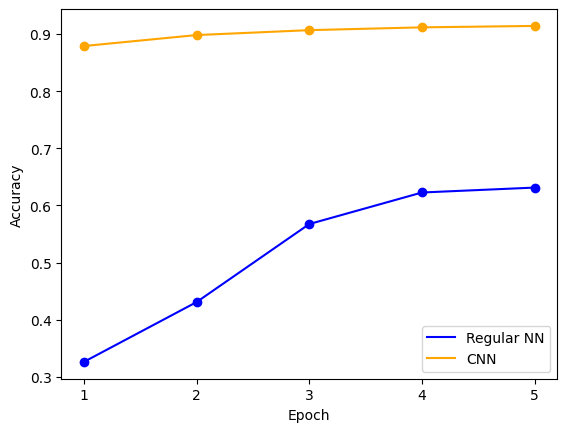

In [34]:
plt.subplot()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
X = np.arange(1, 6)
plt.xticks(X)
plt.plot(X, np.array(test_acc1).T, c="blue", label="Regular NN")
plt.scatter(X, np.array(test_acc1).T, c="blue")
plt.plot(X, np.array(test_acc2).T, c="orange", label="CNN")
plt.scatter(X, np.array(test_acc2).T, c="orange")
plt.legend()
plt.show()